# Performance comparison of pandas crosstab, groupby and pivot_table

The pandas library is very powerful and offers several ways to group and summarize data. Typically, I use the `groupby` method but found `pivot_table` to be more readable when grouping across multiple columns with the intention to visualize the results. After running into memory issues with `pivot_table` I decided to compare these two options and the `crosstab` method.

In this notebook I'll do a short comparison of the runtime and memory use of `groupby`, `pivot_table` and `crosstab`. Let's first look at a DataFrame consisiting of 10 columns and 100,000 rows of random integers between 1 and 100. The DataFrame will be grouped by the columns `A` and `B` counting the values in column `C`. The three operations result in DataFrames containing the same values.

In [75]:
%matplotlib inline
%load_ext memory_profiler
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ramiro')
cols = list(ascii_uppercase[:10])
np.random.seed(42)
data = np.random.randint(1, 100, size=(100_000, 10))
df = pd.DataFrame(data, columns=cols)
df.head()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


,A,B,C,D,E,F,G,H,I,J
0,52,93,15,72,61,21,83,87,75,75
1,88,24,3,22,53,2,88,30,38,2
2,64,60,21,33,76,58,22,89,49,91
3,59,42,92,60,80,15,62,62,47,62
4,51,55,64,3,51,7,21,73,39,18


In [76]:
%%timeit
df.groupby(['A', 'B'])['C'].count().unstack(fill_value=0)

6.97 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [77]:
%%timeit
df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)

32.9 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
%%timeit
pd.crosstab(index=df.A, columns=df.B)

70.5 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


For the first test case the `groupby` DataFrame method followed by a call to `unstack` is clearly the fastest way to do the calculation. I think the `pivot_table` option makes it more obvious what the result will look like, when spelling out the keyword arguments, but it is much slower. The `crosstab` option saves you some typing at the cost of being slow and in my opionion the hardest to understand just by looking at the code.

Next, let's look at data frames of different sizes and check the memory usage. We create wrapper functions that can easily be passed to the `timeit` and `memory_usage` functions in the following loop, where duration and memory usage is measured for data frames ranging from 10 to 1 million rows.

In [112]:
import timeit

from collections import defaultdict
from memory_profiler import memory_usage


def crosstab(df):
    pd.crosstab(index=df.A, columns=df.B)


def groupby(df):
    df.groupby(['A', 'B'])['C'].count().unstack(fill_value=0)


def pivot_table(df):
    df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)


funcs = [crosstab, groupby, pivot_table]
measurements = []

np.random.seed(420) # use a distinct seed as above to prevent caching
for size in np.logspace(1, 6, 6):
    size = int(size)
    repetitions = 10
    
    data = np.random.randint(1, 100, size=(size, 10))
    df = pd.DataFrame(data, columns=cols)
    
    for func in funcs:
        duration = timeit.timeit('func(df)', number=repetitions, globals=globals()) / repetitions
        memory = np.mean(memory_usage(proc=(func, (df,))))
        measurements.append({'Function': func.__name__, 'Row count': size, 'duration': duration, 'memory': memory})
        
df_measurements = pd.DataFrame(measurements)
df_measurements.head(6)

,Function,Row count,duration,memory
0,crosstab,10,0.011494,256.054688
1,groupby,10,0.002040,256.054688
2,pivot_table,10,0.009597,256.054688
3,crosstab,100,0.023391,256.054688
4,groupby,100,0.001906,256.054688
5,pivot_table,100,0.021528,256.054688


Finally, the results are plotted as bar charts to make the differences in duration visible.

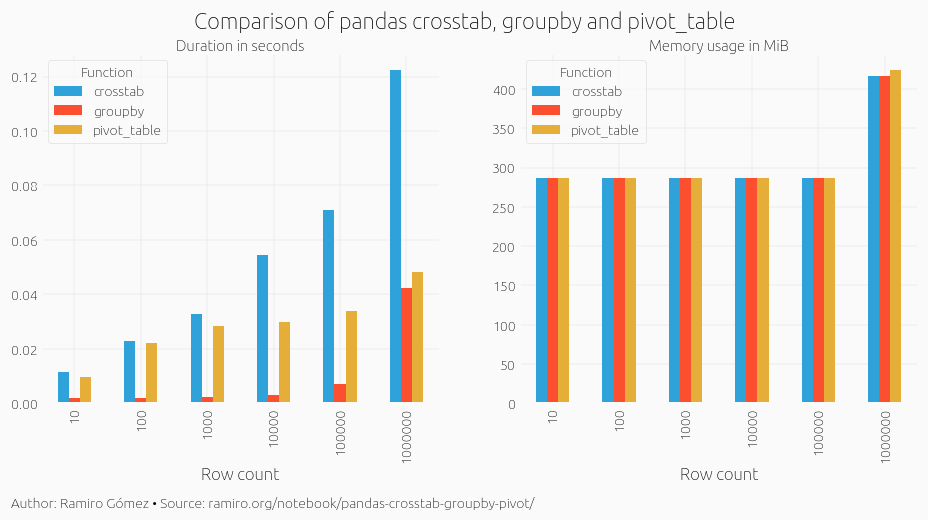

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(14, 6))

ax_dur = axes[0]
ax_mem = axes[1]

df_dur = df_measurements.groupby(['Row count', 'Function']).duration.mean().unstack()
df_mem = df_measurements.groupby(['Row count', 'Function']).memory.mean().unstack()

plot_dur = df_dur.plot(ax=ax_dur, kind='bar')
plot_mem = df_mem.plot(ax=ax_mem, kind='bar')

ax_dur.set_title('Duration in seconds', fontsize=15, va='top')
ax_mem.set_title('Memory usage in MiB', fontsize=15, va='top')

fig.suptitle('Comparison of pandas crosstab, groupby and pivot_table', fontsize=22)
fig.text(0.05, -0.16, 'Author: Ramiro Gómez • Source: ramiro.org/notebook/pandas-crosstab-groupby-pivot/', ha='left', va='center', fontsize=14);

Up until 100,000 rows `groupby` is a lot faster than the two other options. With 1 million rows `groupby` and `pivot_table` take a similar amount of time. Memory usage is the same for all 3 functions until 100,000 rows. For 1 million records `pivot_table` consumes a little more memory.